# Predicting Energy Consumption using Facebook Prophet
This project is aimed to predict energy consumption based on datetime and American Electric Power estimated energy consumption in Megawatts (MW) using Prophet.

In [101]:
import pandas as pd
from prophet import Prophet

First we import the data

In [102]:
df=pd.read_csv("AEP_hourly.csv")

Let's visualize the data

In [103]:
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [104]:
df.tail()

,Datetime,AEP_MW
121268,2018-01-01 20:00:00,21089.0
121269,2018-01-01 21:00:00,20999.0
121270,2018-01-01 22:00:00,20820.0
121271,2018-01-01 23:00:00,20415.0
121272,2018-01-02 00:00:00,19993.0


In [105]:
df.describe()

,AEP_MW
count,121273.000000
mean,15499.513717
std,2591.399065
min,9581.000000
25%,13630.000000
50%,15310.000000
75%,17200.000000
max,25695.000000


In [106]:
df.isnull().any()

Datetime    False
AEP_MW      False
dtype: bool

Now that we have correctly imported the data, it's time to clean the data for a EDA.

In [107]:
# The day and hour are in the same column so we need to split them
def split_datetime(column,sep):
    return column.str.split(sep,expand=True)

In [108]:
dateAndHour=split_datetime(df["Datetime"]," ")
dateAndHour.head()

,0,1
0,2004-12-31,01:00:00
1,2004-12-31,02:00:00
2,2004-12-31,03:00:00
3,2004-12-31,04:00:00
4,2004-12-31,05:00:00


In [109]:
yymmdd=split_datetime(dateAndHour[0],"-")
yymmdd

,0,1,2
0,2004,12,31
1,2004,12,31
2,2004,12,31
3,2004,12,31
4,2004,12,31
...,...,...,...
121268,2018,01,01
121269,2018,01,01
121270,2018,01,01
121271,2018,01,01


The hour only has one part of our interest, we can confirm this by using **unique()** method

In [110]:
dateAndHour[1].unique()

array(['01:00:00', '02:00:00', '03:00:00', '04:00:00', '05:00:00',
       '06:00:00', '07:00:00', '08:00:00', '09:00:00', '10:00:00',
       '11:00:00', '12:00:00', '13:00:00', '14:00:00', '15:00:00',
       '16:00:00', '17:00:00', '18:00:00', '19:00:00', '20:00:00',
       '21:00:00', '22:00:00', '23:00:00', '00:00:00'], dtype=object)

Let's extract the hour only

In [111]:
#for that we are using 0 at the end of the cell below
hour=split_datetime(dateAndHour[1],":")[0] 
hour

0         01
1         02
2         03
3         04
4         05
          ..
121268    20
121269    21
121270    22
121271    23
121272    00
Name: 0, Length: 121273, dtype: object

The next thing to do is to merge all the dataframes into a single one

In [112]:
data=pd.concat([df["AEP_MW"],dateAndHour,yymmdd,hour],axis=1)

In [113]:
data

,AEP_MW,0,1,0,1,2,0
0,13478.0,2004-12-31,01:00:00,2004,12,31,01
1,12865.0,2004-12-31,02:00:00,2004,12,31,02
2,12577.0,2004-12-31,03:00:00,2004,12,31,03
3,12517.0,2004-12-31,04:00:00,2004,12,31,04
4,12670.0,2004-12-31,05:00:00,2004,12,31,05
...,...,...,...,...,...,...,...
121268,21089.0,2018-01-01,20:00:00,2018,01,01,20
121269,20999.0,2018-01-01,21:00:00,2018,01,01,21
121270,20820.0,2018-01-01,22:00:00,2018,01,01,22
121271,20415.0,2018-01-01,23:00:00,2018,01,01,23


For simplicity, the columns have to be renamed, for better readability

In [114]:
columnNames=["Energy consumed","Date","Hour/Minutes/Seconds","Year","Month","Day","Hour"]
data.columns=columnNames

Finally we can see our clean data

In [115]:
data

,Energy consumed,Date,Hour/Minutes/Seconds,Year,Month,Day,Hour
0,13478.0,2004-12-31,01:00:00,2004,12,31,01
1,12865.0,2004-12-31,02:00:00,2004,12,31,02
2,12577.0,2004-12-31,03:00:00,2004,12,31,03
3,12517.0,2004-12-31,04:00:00,2004,12,31,04
4,12670.0,2004-12-31,05:00:00,2004,12,31,05
...,...,...,...,...,...,...,...
121268,21089.0,2018-01-01,20:00:00,2018,01,01,20
121269,20999.0,2018-01-01,21:00:00,2018,01,01,21
121270,20820.0,2018-01-01,22:00:00,2018,01,01,22
121271,20415.0,2018-01-01,23:00:00,2018,01,01,23


In [116]:
data.dtypes

Energy consumed         float64
Date                     object
Hour/Minutes/Seconds     object
Year                     object
Month                    object
Day                      object
Hour                     object
dtype: object

With the clean data, it's time to plot and see the energy consumption

In [117]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

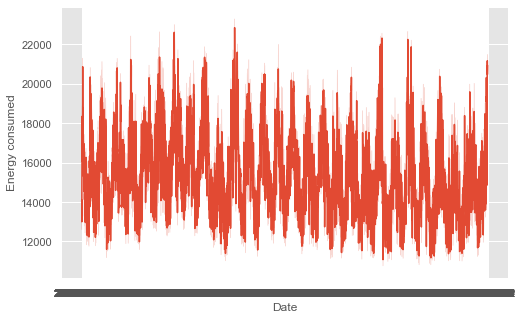

In [118]:
plt.style.use("ggplot")
sns.lineplot(x="Date",y="Energy consumed",data=data)
plt.show()

In [119]:
yearKW=data.groupby(by="Year").sum()
yearKW

,Energy consumed
Year,
2004,33479854.0
2005,138752914.0
2006,137826610.0
2007,145781458.0
2008,145224910.0
2009,133595510.0
2010,140187481.0
2011,138511181.0
2012,134814172.0


As it's seen the year 2004 ans 2018 are incomplete. This can be seen in the code below.

In [120]:
subset2004=data[data["Year"]=="2004"]
len(subset2004["Date"].unique())

92

Only 92 days are recorded for 2004.

Let's do the same for 2018

In [121]:
subset2018=data[data["Year"]=="2018"]
len(subset2018.Date.unique())

215

This year has only 215 days recorded, so if we want to compare the energy consumption, we need to delete records from 2004 and 2018

In [122]:
completeYearRecords=data[(data["Year"]!="2004") & (data["Year"]!="2018")]
completeYearRecordsGrouped=completeYearRecords.groupby("Year").sum()
completeYearRecordsGrouped

,Energy consumed
Year,
2005,138752914.0
2006,137826610.0
2007,145781458.0
2008,145224910.0
2009,133595510.0
2010,140187481.0
2011,138511181.0
2012,134814172.0
2013,133105937.0


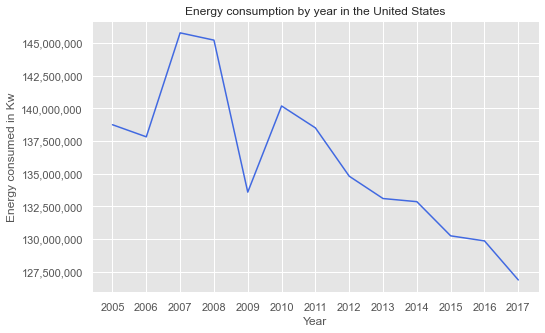

In [123]:
sns.lineplot(x="Year",y="Energy consumed",data=completeYearRecordsGrouped,color="royalblue")
sns.set(rc={'figure.figsize':(8,5)})
plt.title("Energy consumption by year in the United States")
plt.ylabel("Energy consumed in Kw")
valores_con_comas = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in valores_con_comas])
plt.show()

We see that the Energy Consumed in USA has decreased since the Financial crisis of 2007–2008.

Now it's necessary to transform hour into a numerical value

In [124]:
data.Hour=data.Hour.astype(int)

In [125]:
data.dtypes

Energy consumed         float64
Date                     object
Hour/Minutes/Seconds     object
Year                     object
Month                    object
Day                      object
Hour                      int32
dtype: object

In [127]:
data

,Energy consumed,Date,Hour/Minutes/Seconds,Year,Month,Day,Hour
0,13478.0,2004-12-31,01:00:00,2004,12,31,1
1,12865.0,2004-12-31,02:00:00,2004,12,31,2
2,12577.0,2004-12-31,03:00:00,2004,12,31,3
3,12517.0,2004-12-31,04:00:00,2004,12,31,4
4,12670.0,2004-12-31,05:00:00,2004,12,31,5
...,...,...,...,...,...,...,...
121268,21089.0,2018-01-01,20:00:00,2018,01,01,20
121269,20999.0,2018-01-01,21:00:00,2018,01,01,21
121270,20820.0,2018-01-01,22:00:00,2018,01,01,22
121271,20415.0,2018-01-01,23:00:00,2018,01,01,23


The next thing to do is to see the difference of energy consumption based on the month and hour of the day

For the graph, I'll be using year 2017 as an example

In [128]:
KwConsumed2017=data[data["Year"]=="2017"]
KwConsumed2017grouped=KwConsumed2017.groupby(["Hour","Month"]).sum()
#This is done to recover the column Hour
KwConsumed2017grouped.reset_index(inplace=True) 
KwConsumed2017grouped

,Hour,Month,Energy consumed
0,0,01,453672.0
1,0,02,388353.0
2,0,03,428358.0
3,0,04,364121.0
4,0,05,381508.0
...,...,...,...
283,23,08,466243.0
284,23,09,410226.0
285,23,10,408764.0
286,23,11,423431.0


Creating a new column will be useful for classifying the Kw consumption by the part of the Day

In [129]:
import numpy as np
conditions = [
       ((KwConsumed2017grouped['Hour'] >= 0 ) & (KwConsumed2017grouped['Hour'] <= 5) | (KwConsumed2017grouped['Hour']>=21)), 
       ((KwConsumed2017grouped['Hour'] >= 6 ) & (KwConsumed2017grouped['Hour'] <= 14)),
       ((KwConsumed2017grouped['Hour'] >= 14 ) & (KwConsumed2017grouped['Hour'] <= 20))]


result=["Night","Morning","Afternoon"]

KwConsumed2017grouped['Part Of Day'] = np.select(conditions, result)
KwConsumed2017grouped

,Hour,Month,Energy consumed,Part Of Day
0,0,01,453672.0,Night
1,0,02,388353.0,Night
2,0,03,428358.0,Night
3,0,04,364121.0,Night
4,0,05,381508.0,Night
...,...,...,...,...
283,23,08,466243.0,Night
284,23,09,410226.0,Night
285,23,10,408764.0,Night
286,23,11,423431.0,Night


Let's see the graph

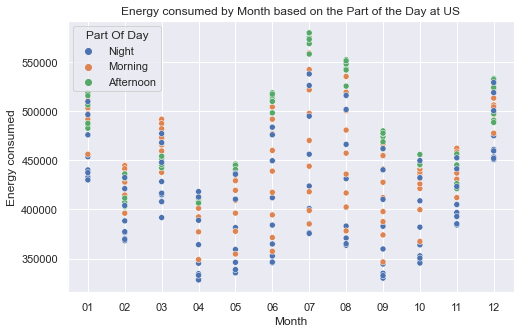

In [133]:
sns.scatterplot(x="Month",y="Energy consumed",data=KwConsumed2017grouped,hue="Part Of Day")
plt.title("Energy consumed by Month based on the Part of the Day at US")
plt.show()

The graph shows that between seasons, the part of the day where the americans consume more energy changes, but we can definitely say that **the night, is the part of the day where less energy is consumed**.

Now that we have already explored the data, it's time to make predictions, for that the data has to be reshaped in a useful way.

In [135]:
KwConsumedByDate=data.groupby(by="Date").sum().iloc[:,:-1:]
KwConsumedByDate.reset_index(inplace=True)
KwConsumedByDate

,Date,Energy consumed
0,2004-10-01,328544.0
1,2004-10-02,311997.0
2,2004-10-03,293450.0
3,2004-10-04,343417.0
4,2004-10-05,346553.0
...,...,...
5050,2018-07-30,368834.0
5051,2018-07-31,364327.0
5052,2018-08-01,363628.0
5053,2018-08-02,376504.0


In [140]:
#the columns have to be renamed into ds and y
KwConsumedByDate.columns=["ds","y"]

#create the model
model=Prophet()

#train the model
model.fit(KwConsumedByDate)


20:37:38 - cmdstanpy - INFO - Chain [1] start processing
20:37:39 - cmdstanpy - INFO - Chain [1] done processing


Now that the model was created, let's make predictions of the next year.

In [142]:
#add 365 new periods (days)
future = model.make_future_dataframe(periods=365)

#predict the new periods Kw consumption
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
5415,2019-07-30,402475.746973,365858.866934,440130.750102
5416,2019-07-31,400651.696619,360473.588550,438395.323760
5417,2019-08-01,400154.093071,362258.769824,440454.080136
5418,2019-08-02,392725.805927,354666.196817,430945.270121
5419,2019-08-03,364567.353584,326382.544877,404906.913799


(200000.0, 575026.0)

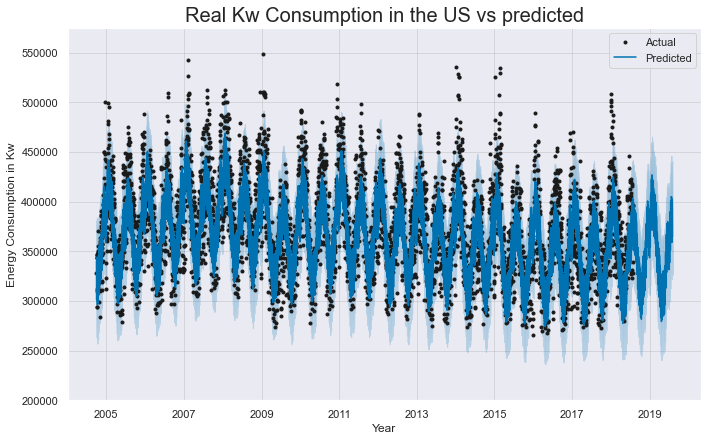

In [151]:
fig1 = model.plot(forecast)
plt.title("Real Kw Consumption in the US vs predicted",fontsize=20)
plt.xlabel("Year",fontsize=12)
plt.ylabel("Energy Consumption in Kw",fontsize=12)
plt.legend(["Actual","Predicted"])
plt.ylim(200000)


As it can be seen, the model fits well with the actual data, the trend is that **Kw consumption is lower as the time passes**. My assumption is that ass the technology gets better energy efficiency, the Kw consumption decreases.